## LSTM Donor Choose

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href=''https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics>'auc'</a> as a metric. check <a href'https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

## Preprocessing

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM, Dropout, Concatenate, Conv1D,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from time import ctime


from tensorflow.keras.callbacks  import TensorBoard

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

In [2]:
project_data = pd.read_csv('train_data.csv')

In [3]:
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [4]:
project_data.shape

(109248, 17)

In [5]:
resource_data = pd.read_csv('resources.csv')

In [6]:
resource_data.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [7]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head()

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [8]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [9]:
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,232.90,4
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,67.98,4


In [10]:
def checkNumber(text):
    flag = bool(re.search(r'\d', text))
    if flag:
        return 1
    else :
        return 0

In [11]:
project_data['project_resource_summary'] = project_data['project_resource_summary'].apply(checkNumber)

### Splitting into train,test

In [12]:
cols = [0,1,2,5,9,16]
X = project_data.drop(project_data.columns[cols],axis=1)
Y = project_data['project_is_approved']

In [13]:
X.shape

(109248, 13)

In [14]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2)

for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1)

for train_index, test_index in sss.split(X_train, y_train):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[test_index]

In [15]:
y_train = pd.get_dummies(y_train)

In [16]:
y_val = pd.get_dummies(y_val)

In [17]:
y_test = pd.get_dummies(y_test)

### Cleaning

In [18]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [20]:
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

### Project essay

In [21]:
X_train["essay"] = X_train["project_essay_1"].map(str) +\
                        X_train["project_essay_2"].map(str) + \
                        X_train["project_essay_3"].map(str) + \
                        X_train["project_essay_4"].map(str)

In [22]:
X_val["essay"] = X_val["project_essay_1"].map(str) +\
                        X_val["project_essay_2"].map(str) + \
                        X_val["project_essay_3"].map(str) + \
                        X_val["project_essay_4"].map(str)

In [23]:
X_test["essay"] = X_test["project_essay_1"].map(str) +\
                        X_test["project_essay_2"].map(str) + \
                        X_test["project_essay_3"].map(str) + \
                        X_test["project_essay_4"].map(str)

In [24]:
preprocessed_essays_train = preprocess_text(X_train['essay'].values)

100%|██████████| 78658/78658 [00:53<00:00, 1477.75it/s]


In [25]:
preprocessed_essays_val = preprocess_text(X_val['essay'].values)

100%|██████████| 8740/8740 [00:05<00:00, 1477.29it/s]


In [26]:
preprocessed_essays_test = preprocess_text(X_test['essay'].values)

100%|██████████| 21850/21850 [00:14<00:00, 1464.55it/s]


In [27]:
with open('glove_vectors', 'rb') as f:
    glove = pickle.load(f)

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_essays_train)

In [29]:
token_train = tokenizer.texts_to_sequences(preprocessed_essays_train)

In [30]:
token_val = tokenizer.texts_to_sequences(preprocessed_essays_val)

In [31]:
token_test = tokenizer.texts_to_sequences(preprocessed_essays_test)

In [32]:
MAX_SEQUENCE_LENGTH = 500
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
final_train = pad_sequences(token_train, maxlen=MAX_SEQUENCE_LENGTH)
final_val = pad_sequences(token_val, maxlen=MAX_SEQUENCE_LENGTH)
final_test = pad_sequences(token_test, maxlen=MAX_SEQUENCE_LENGTH)

Found 49287 unique tokens.


In [33]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [34]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### School State

In [35]:
input_school_state_train = X_train['school_state'].str.lower()

In [36]:
input_school_state_val = X_val['school_state'].str.lower()

In [37]:
input_school_state_test = X_test['school_state'].str.lower()

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_state = MultiLabelBinarizer()
multilabel_state.fit(input_school_state_train)
labels1 = multilabel_state.classes_

In [39]:
keywords_school_state_train = multilabel_state.transform(input_school_state_train)
keywords_school_state_val = multilabel_state.transform(input_school_state_val)
keywords_school_state_test = multilabel_state.transform(input_school_state_test)

In [40]:
keywords_school_state_train.shape

(78658, 24)

In [41]:
school_layer = Embedding(len(labels1) + 1,
                            24,
                            input_length=24,
                            trainable=False)

### Project Grade Category

In [42]:
X_train['project_grade_category'] = X_train['project_grade_category'].str.replace(' ','_')
X_train['project_grade_category'] = X_train['project_grade_category'].str.replace('-','_')
project_grade_category_train = X_train['project_grade_category'].str.lower()

In [43]:
X_val['project_grade_category'] = X_val['project_grade_category'].str.replace(' ','_')
X_val['project_grade_category'] = X_val['project_grade_category'].str.replace('-','_')
project_grade_category_val = X_val['project_grade_category'].str.lower()

In [44]:
X_test['project_grade_category'] = X_test['project_grade_category'].str.replace(' ','_')
X_test['project_grade_category'] = X_test['project_grade_category'].str.replace('-','_')
project_grade_category_test = X_test['project_grade_category'].str.lower()

In [45]:
multilabel_grade = MultiLabelBinarizer()
multilabel_grade.fit(project_grade_category_train)
labels2 = multilabel_grade.classes_

In [46]:
keywords_grade_train = multilabel_grade.transform(project_grade_category_train)
keywords_grade_val = multilabel_grade.transform(project_grade_category_val)
keywords_grade_test = multilabel_grade.transform(project_grade_category_test)

In [47]:
keywords_grade_train.shape

(78658, 16)

In [48]:
grade_layer = Embedding(len(labels2) + 1,
                            16,
                            input_length=16,
                            trainable=False)

### Input Clean Category

In [49]:
X_train['project_subject_categories'] = X_train['project_subject_categories'].str.replace(' The ','')
X_train['project_subject_categories'] = X_train['project_subject_categories'].str.replace(' ','')
X_train['project_subject_categories'] = X_train['project_subject_categories'].str.replace('&','_')
X_train['project_subject_categories'] = X_train['project_subject_categories'].str.replace(',','_')
input_clean_category_train = X_train['project_subject_categories'].str.lower()

In [50]:
X_val['project_subject_categories'] = X_val['project_subject_categories'].str.replace(' The ','')
X_val['project_subject_categories'] = X_val['project_subject_categories'].str.replace(' ','')
X_val['project_subject_categories'] = X_val['project_subject_categories'].str.replace('&','_')
X_val['project_subject_categories'] = X_val['project_subject_categories'].str.replace(',','_')
input_clean_category_val = X_val['project_subject_categories'].str.lower()

In [51]:
X_test['project_subject_categories'] = X_test['project_subject_categories'].str.replace(' The ','')
X_test['project_subject_categories'] = X_test['project_subject_categories'].str.replace(' ','')
X_test['project_subject_categories'] = X_test['project_subject_categories'].str.replace('&','_')
X_test['project_subject_categories'] = X_test['project_subject_categories'].str.replace(',','_')
input_clean_category_test = X_test['project_subject_categories'].str.lower()

In [52]:
multilabel_cat = MultiLabelBinarizer()
multilabel_cat.fit(input_clean_category_train)
labels3 = multilabel_cat.classes_

In [53]:
keywords_cat_train = multilabel_cat.transform(input_clean_category_train)
keywords_cat_val = multilabel_cat.transform(input_clean_category_val)
keywords_cat_test = multilabel_cat.transform(input_clean_category_test)

In [54]:
keywords_cat_train.shape

(78658, 20)

In [55]:
cat_layer = Embedding(len(labels3) + 1,
                            20,
                            input_length=20,
                            trainable=False)

### Input Clean SubCategory

In [56]:
X_train['project_subject_subcategories'] = X_train['project_subject_subcategories'].str.replace(' The ','')
X_train['project_subject_subcategories'] = X_train['project_subject_subcategories'].str.replace(' ','')
X_train['project_subject_subcategories'] = X_train['project_subject_subcategories'].str.replace('&','_')
X_train['project_subject_subcategories'] = X_train['project_subject_subcategories'].str.replace(',','_')
input_clean_subcategory_train = X_train['project_subject_subcategories'].str.lower()

In [57]:
X_val['project_subject_subcategories'] = X_val['project_subject_subcategories'].str.replace(' The ','')
X_val['project_subject_subcategories'] = X_val['project_subject_subcategories'].str.replace(' ','')
X_val['project_subject_subcategories'] = X_val['project_subject_subcategories'].str.replace('&','_')
X_val['project_subject_subcategories'] = X_val['project_subject_subcategories'].str.replace(',','_')
input_clean_subcategory_val = X_val['project_subject_subcategories'].str.lower()

In [58]:
X_test['project_subject_subcategories'] = X_test['project_subject_subcategories'].str.replace(' The ','')
X_test['project_subject_subcategories'] = X_test['project_subject_subcategories'].str.replace(' ','')
X_test['project_subject_subcategories'] = X_test['project_subject_subcategories'].str.replace('&','_')
X_test['project_subject_subcategories'] = X_test['project_subject_subcategories'].str.replace(',','_')
input_clean_subcategory_test = X_test['project_subject_subcategories'].str.lower()

In [59]:
multilabel_sub = MultiLabelBinarizer()
multilabel_sub.fit(input_clean_subcategory_train)
labels4 = multilabel_sub.classes_

In [60]:
keywords_sub_train = multilabel_sub.transform(input_clean_subcategory_train)
keywords_sub_val = multilabel_sub.transform(input_clean_subcategory_val)
keywords_sub_test = multilabel_sub.transform(input_clean_subcategory_test)

In [61]:
keywords_sub_train.shape

(78658, 22)

In [62]:
sub_layer = Embedding(len(labels4) + 1,
                            22,
                            input_length=22,
                            trainable=False)

### Input Teacher Prefix

In [63]:
X_train['teacher_prefix']=X_train['teacher_prefix'].fillna('Mrs.')
X_train['teacher_prefix'] = X_train['teacher_prefix'].str.replace('.','')
input_teacher_prefix_train = X_train['teacher_prefix'].str.lower()

In [64]:
X_val['teacher_prefix']=X_val['teacher_prefix'].fillna('Mrs.')
X_val['teacher_prefix'] = X_val['teacher_prefix'].str.replace('.','')
input_teacher_prefix_val = X_val['teacher_prefix'].str.lower()

In [65]:
X_test['teacher_prefix']=X_test['teacher_prefix'].fillna('Mrs.')
X_test['teacher_prefix'] = X_test['teacher_prefix'].str.replace('.','')
input_teacher_prefix_test = X_test['teacher_prefix'].str.lower()

In [66]:
multilabel_tech = MultiLabelBinarizer()
multilabel_tech.fit(input_teacher_prefix_train)
labels5 = multilabel_tech.classes_

In [67]:
keywords_tech_train = multilabel_tech.transform(input_teacher_prefix_train)
keywords_tech_val = multilabel_tech.transform(input_teacher_prefix_val)
keywords_tech_test = multilabel_tech.transform(input_teacher_prefix_test)

In [68]:
keywords_tech_train.shape

(78658, 9)

In [69]:
tech_layer = Embedding(len(labels5) + 1,
                            9,
                            input_length=9,
                            trainable=False)

### Number of posted projects, contains number, price, quantity

In [70]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train['price'] = min_max_scaler.fit_transform(X_train[['price']])
X_val['price'] = min_max_scaler.transform(X_val[['price']])
X_test['price'] = min_max_scaler.transform(X_test[['price']])

In [71]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train['quantity'] = min_max_scaler.fit_transform(X_train[['quantity']])
X_val['quantity'] = min_max_scaler.transform(X_val[['quantity']])
X_test['quantity'] = min_max_scaler.transform(X_test[['quantity']])

In [72]:
extra_train = X_train[['project_resource_summary','price','quantity']]

In [73]:
extra_val = X_val[['project_resource_summary','price','quantity']]

In [74]:
extra_test = X_test[['project_resource_summary','price','quantity']]

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [75]:
#input_layer = Input(shape=(n,))
#embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
#flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [76]:
import sklearn.metrics as sklm

def auc_temp(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return sklm.roc_auc_score(y_true, y_pred)

def auc(y_true, y_pred):
    return tf.py_function(auc_temp, (y_true, y_pred), tf.double)

In [77]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name='textdata')
embedded_sequences = embedding_layer(sequence_input)
lstm_out = LSTM(500)(embedded_sequences)
lstm_out = Flatten()(embedded_sequences)

In [78]:
school_input = Input(shape=(24,), dtype='int32', name='schoolinput')
school_sequences = school_layer(school_input)
school_out = Flatten()(school_sequences)

In [79]:
grade_input = Input(shape=(16,), dtype='int32', name='gradeinput')
grade_sequences = grade_layer(grade_input)
grade_out = Flatten()(grade_sequences)

In [80]:
cat_input = Input(shape=(20,), dtype='int32', name='catinput')
cat_sequences = cat_layer(cat_input)
cat_out = Flatten()(grade_sequences)

In [81]:
sub_input = Input(shape=(22,), dtype='int32', name='subinput')
sub_sequences = sub_layer(sub_input)
sub_out = Flatten()(sub_sequences)

In [82]:
tech_input = Input(shape=(9,), dtype='int32', name='techinput')
tech_sequences = tech_layer(tech_input)
tech_out = Flatten()(tech_sequences)

In [83]:
extra_input = Input(shape=(3,), name='extrainput')
extra_out = Dense(3, activation='relu')(extra_input)

In [84]:
tensorboard = TensorBoard(log_dir='./logs/{}'.format(ctime()),histogram_freq=1)

In [85]:
def Eval(score, targ):
    auc = sklm.roc_auc_score(targ, score)

    return auc

In [86]:
model_1 = tf.keras.layers.concatenate([lstm_out, school_out, grade_out,cat_out,sub_out ,tech_out,extra_out])
m1 = Dense(256, activation='relu')(model_1)
m1 = BatchNormalization()(m1)
m1 = Dropout(0.5)(m1)
m1 = BatchNormalization()(m1)
m1 = Dense(256, activation='relu')(m1)
m1 = Dropout(0.5)(m1)
m1 = BatchNormalization()(m1)
m1 = Dense(8, activation='relu')(m1)
m1 = Dense(2, activation='softmax',name='main_output')(m1)

In [87]:
model = Model(inputs=[sequence_input, school_input,  grade_input,cat_input,
                      sub_input,tech_input,extra_input], outputs=[m1])

In [88]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=[auc])

In [89]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
textdata (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
schoolinput (InputLayer)        [(None, 24)]         0                                            
__________________________________________________________________________________________________
gradeinput (InputLayer)         [(None, 16)]         0                                            
__________________________________________________________________________________________________
subinput (InputLayer)           [(None, 22)]         0                                            
______________________________________________________________________________________________

In [90]:
new_dir = 'model/'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
fpath = new_dir + 'weights.{epoch:02d}-{val_auc:.2f}.hdf5'

In [91]:
cp_cb = ModelCheckpoint(fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

W0815 08:14:47.161895 4580795840 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [ ]:
model.fit([final_train, keywords_school_state_train, 
           keywords_grade_train, keywords_cat_train, keywords_sub_train,keywords_tech_train, extra_train], y_train,
           validation_data = ([final_val, keywords_school_state_val, 
           keywords_grade_val, keywords_cat_val, keywords_sub_val,keywords_tech_val, extra_val], y_val),
          epochs=3, batch_size=256, callbacks=[tensorboard])

W0815 08:14:53.767720 4580795840 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0815 08:14:55.895557 4580795840 summary_ops_v2.py:1110] Model failed to serialize as JSON. Ignoring... Could not pack sequence. Structure had 7 elements, but flat_sequence had 6 elements.  Structure: [<tf.Tensor 'textdata:0' shape=(None, 500) dtype=int32>, <tf.Tensor 'schoolinput:0' shape=(None, 24) dtype=int32>, <tf.Tensor 'gradeinput:0' shape=(None, 16) dtype=int32>, <tf.Tensor 'catinput:0' shape=(None, 20) dtype=int32>, <tf.Tensor 'subinput:0' shape=(None, 22) dtype=int32>, <tf.Tensor 'techinput:0' shape=(None, 9) dtype=int32>, <tf.Tensor 'extrainput:0' shape=(None, 3) dtype=float32>], flat_sequence: [<tensorflow.python.kera

Train on 78658 samples, validate on 8740 samples
Epoch 1/3
78658/78658 [==============================] - 182s 2ms/sample - loss: 0.4546 - auc: 0.5915 - val_loss: 0.4150 - val_auc: 0.6666
Epoch 2/3
52224/78658 [==================>...........] - ETA: 1:19 - loss: 0.3790 - auc: 0.7303

In [89]:
score = model.predict([final_test, keywords_school_state_test, 
                         keywords_grade_test, keywords_cat_test, keywords_sub_test,keywords_tech_test,extra_test])

In [90]:
Eval(score,np.array(y_test))

AUC : 0.6677838917437037 - roc_auc_micro_avg_score : 0.8894162434740717


In [91]:
scores = model.evaluate([final_test, keywords_school_state_test, 
                         keywords_grade_test, keywords_cat_test, keywords_sub_test,keywords_tech_test,extra_test],
                        y_test, verbose=0)

In [93]:
print(scores)

0.6225706113776026


### Results for Model 1

Validation Loss


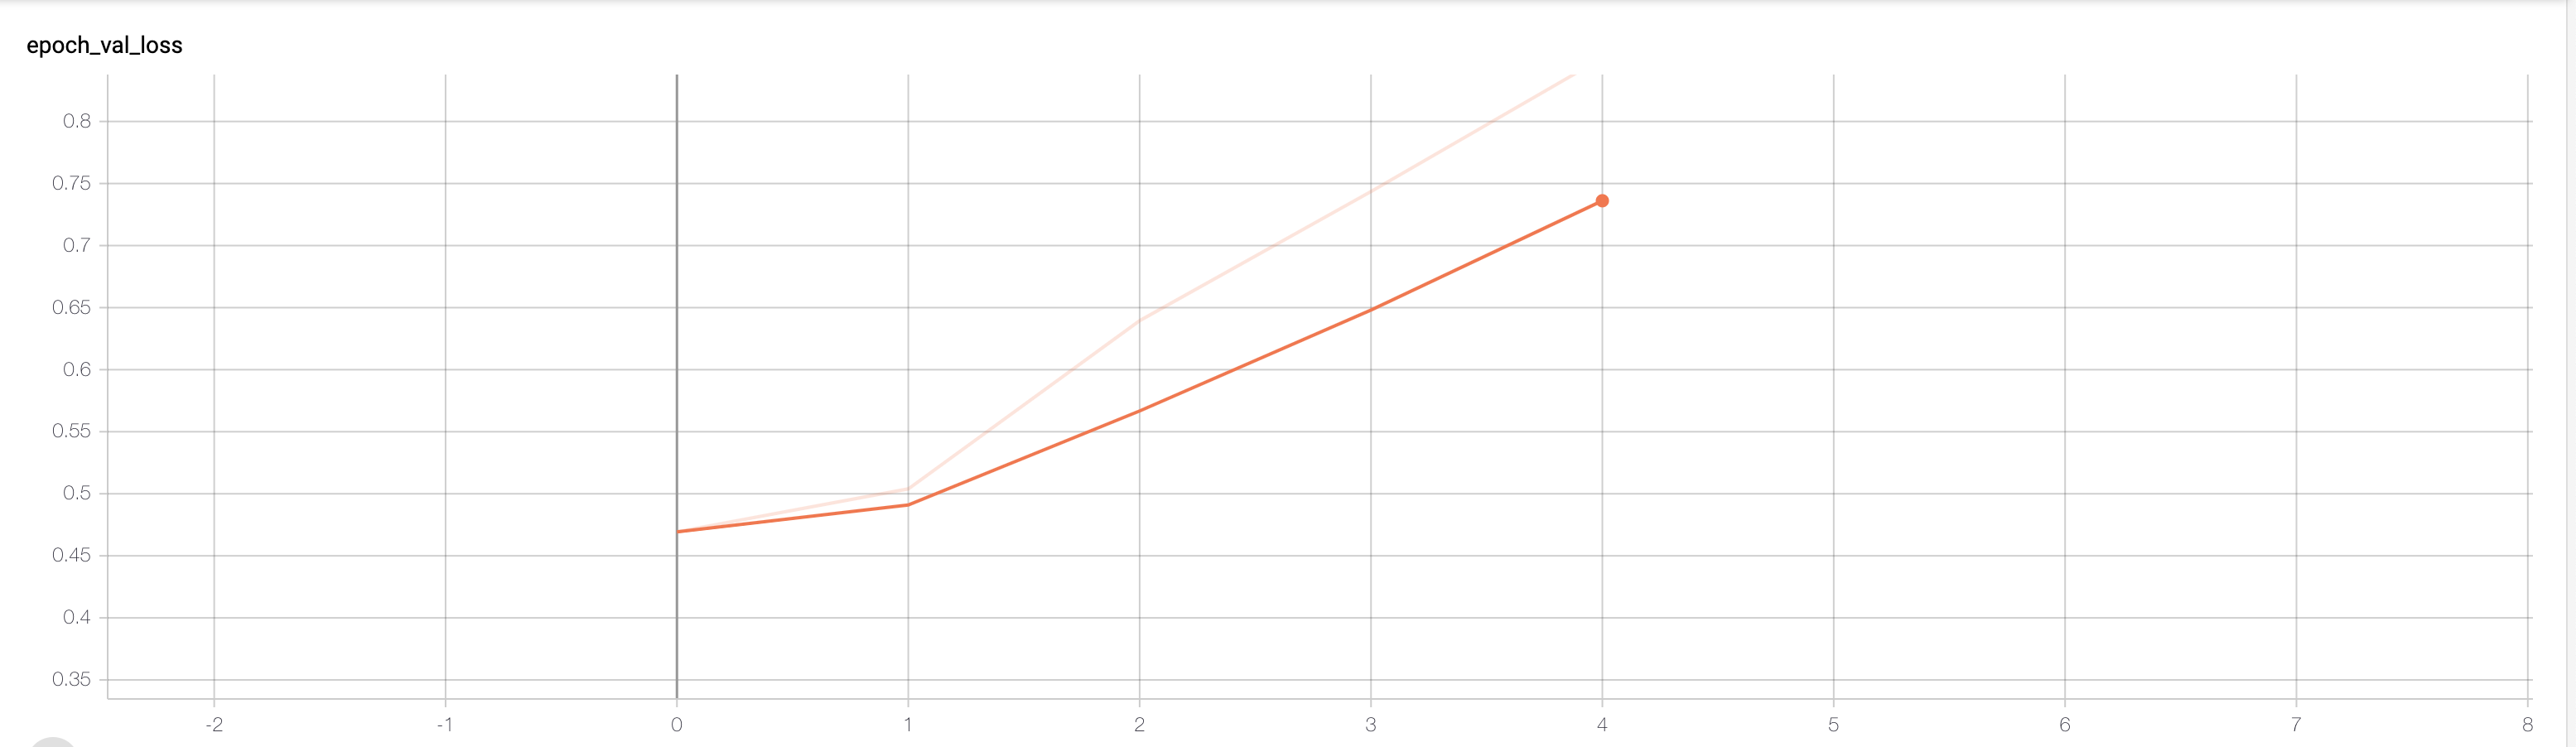

Train Loss


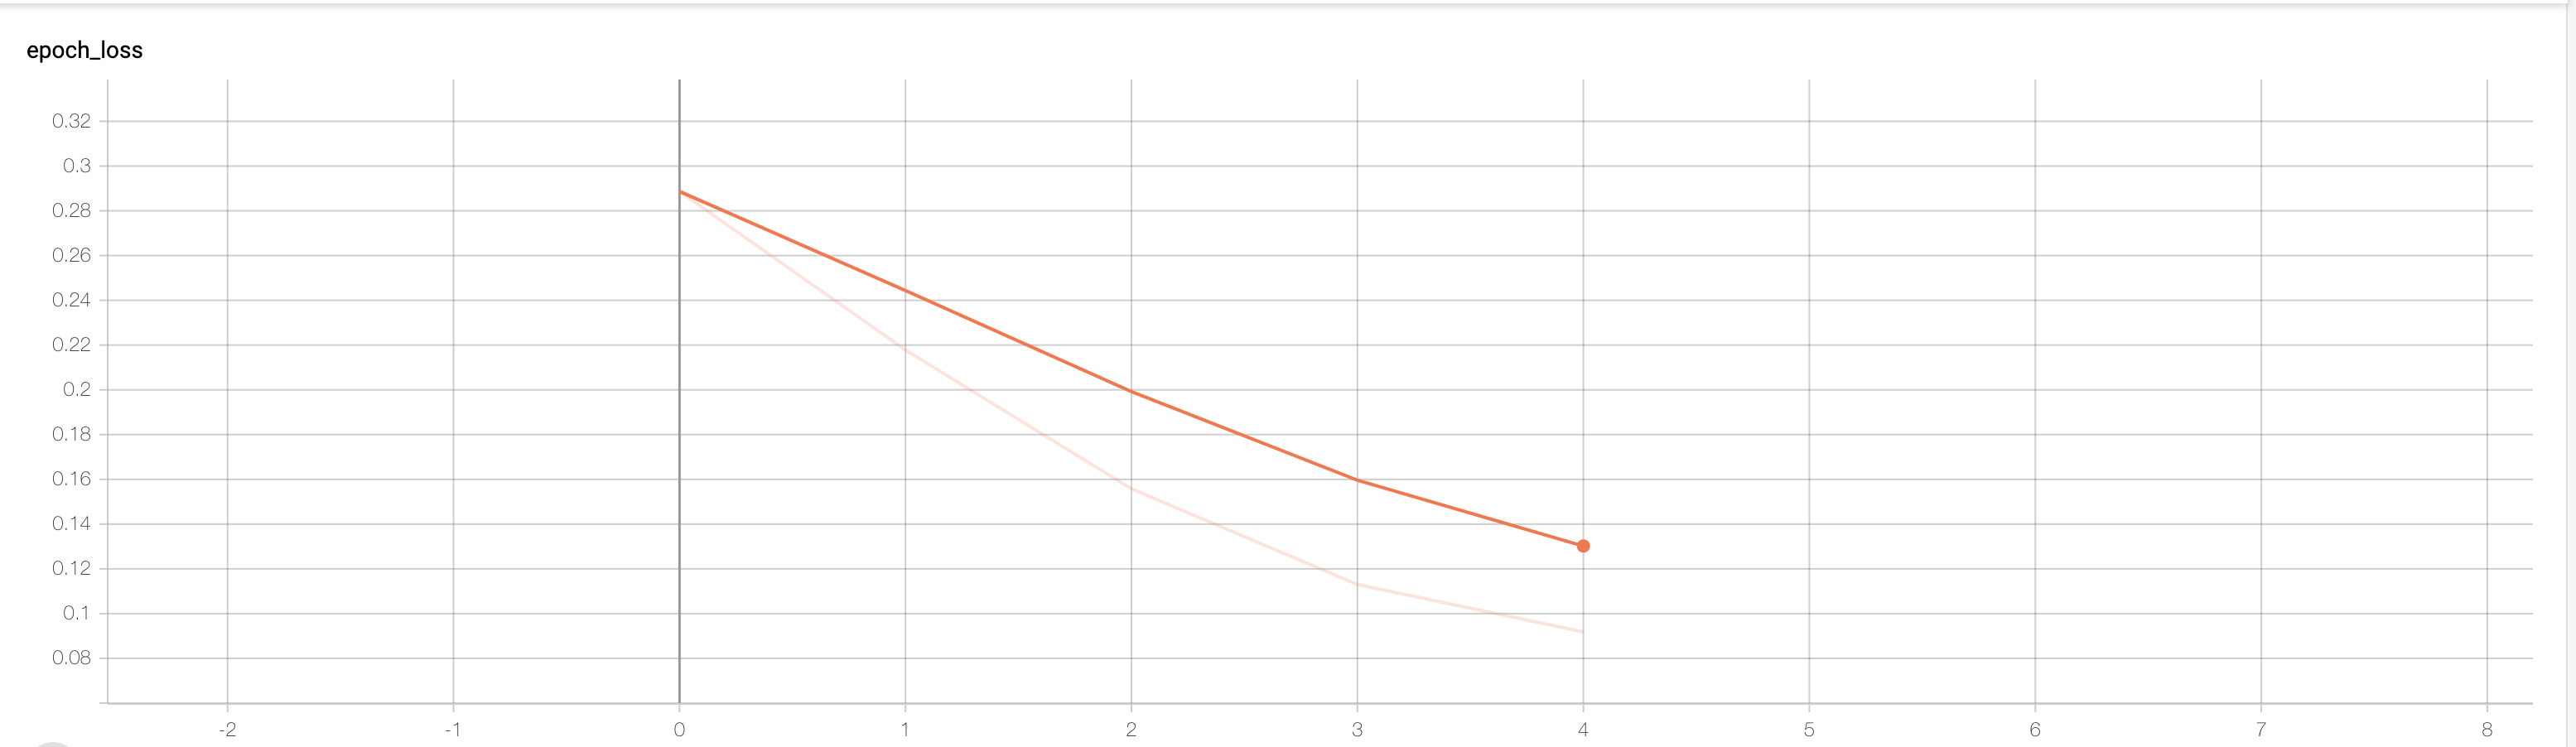

In [119]:
from IPython.display import display, Image
i = Image(filename='./logs/val_loss.png')
print('Validation Loss')
display(i)
i = Image(filename='./logs/loss.png')
print('Train Loss')
display(i)

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,1))
vectorizer.fit(preprocessed_essays_train)

x_train_essay_tfidf = vectorizer.transform(preprocessed_essays_train)

In [89]:
x_train_essay_tfidf.shape

(78658, 14519)

In [90]:
print(len(vectorizer.get_feature_names()))
print(len(vectorizer.idf_))

14519
14519


In [91]:
idfvocab = np.array(vectorizer.get_feature_names())
idfvalues = np.argsort(vectorizer.idf_)

In [92]:
print(np.percentile(vectorizer.idf_[idfvalues],np.arange(0, 100, 25)))

[1.00755462 6.97455997 8.32163361 9.27714506]


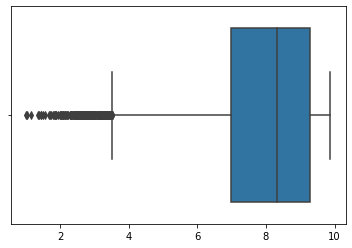

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
splot = sns.boxplot(x=vectorizer.idf_[idfvalues])
plt.show()

In [94]:
print(np.percentile(vectorizer.idf_[idfvalues],np.arange(0, 100, 25)))

[1.00755462 6.97455997 8.32163361 9.27714506]


In [95]:
sorted_idfvalues = vectorizer.idf_[idfvalues]
sorted_vocab = idfvocab[idfvalues]

In [96]:
cutidf = sorted_idfvalues[int(len(vectorizer.idf_)/4):int(len(vectorizer.idf_)*3/4)]
cutvocab = sorted_vocab[int(len(vectorizer.idf_)/4):int(len(vectorizer.idf_)*3/4)]

In [97]:
def removed_tfidf(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sent in tqdm(text_data):
        sent = ' '.join(e for e in sent.split() if e.lower() in cutvocab)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [98]:
train_tfidf = removed_tfidf(preprocessed_essays_train)

100%|██████████| 78658/78658 [11:49<00:00, 114.28it/s]


In [99]:
val_tfidf = removed_tfidf(preprocessed_essays_val)

100%|██████████| 8740/8740 [01:19<00:00, 110.53it/s]


In [100]:
test_tfidf = removed_tfidf(preprocessed_essays_test)

100%|██████████| 21850/21850 [03:18<00:00, 110.14it/s]


In [101]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_tfidf)

In [102]:
tfidf_token_train = tokenizer.texts_to_sequences(train_tfidf)
tfidf_token_val = tokenizer.texts_to_sequences(val_tfidf)
tfidf_token_test = tokenizer.texts_to_sequences(test_tfidf)

In [103]:
MAX_SEQUENCE_LENGTH = 100
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
final_train = pad_sequences(tfidf_token_train, maxlen=MAX_SEQUENCE_LENGTH)
final_val = pad_sequences(tfidf_token_val, maxlen=MAX_SEQUENCE_LENGTH)
final_test = pad_sequences(tfidf_token_test, maxlen=MAX_SEQUENCE_LENGTH)

Found 7260 unique tokens.


In [104]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [105]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [106]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name='textdata')
embedded_sequences = embedding_layer(sequence_input)
lstm_out = LSTM(300)(embedded_sequences)
lstm_out = Flatten()(embedded_sequences)

In [107]:
model_1 = keras.layers.concatenate([lstm_out, school_out, grade_out,cat_out,sub_out ,tech_out, extra_out])
m1 = Dense(256, activation='relu')(model_1)
m1 = Dropout(0.2)(m1)
m1 = Dense(64, activation='relu')(m1)
m1 = Dropout(0.2)(m1)
m1 = Dense(16, activation='relu')(m1)
m1 = Dense(2, activation='softmax',name='main_output')(m1)

In [108]:
model = Model(inputs=[sequence_input, school_input,  grade_input,cat_input,sub_input,tech_input,extra_input], outputs=[m1])

In [109]:
tensorboard = TensorBoard(log_dir='./logs2/{}'.format(time()))

In [110]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[auc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
textdata (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
schoolinput (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
gradeinput (InputLayer)         (None, 16)           0                                            
__________________________________________________________________________________________________
subinput (InputLayer)           (None, 22)           0                                            
__________________________________________________________________________________________________
techinput 

In [111]:
model.fit([final_train, keywords_school_state_train, 
           keywords_grade_train, keywords_cat_train, keywords_sub_train,keywords_tech_train,extra_train],
          [y_train],validation_data = ([final_val, keywords_school_state_val, 
           keywords_grade_val, keywords_cat_val, keywords_sub_val,keywords_tech_val, extra_val], y_val),
          epochs=5, batch_size=32, callbacks=[tensorboard, metrics])

Instructions for updating:
Use tf.cast instead.
Train on 78658 samples, validate on 8740 samples
Epoch 1/5
78658/78658 [==============================] - 304s 4ms/step - loss: 0.4268 - auc: 0.8608 - val_loss: 0.4111 - val_auc: 0.8719
AUC : 0.6494056395925822 - auc_micro_avg : 0.8874648568615849
Epoch 2/5
78658/78658 [==============================] - 303s 4ms/step - loss: 0.3996 - auc: 0.8796 - val_loss: 0.4038 - val_auc: 0.8836
AUC : 0.6686558416944416 - auc_micro_avg : 0.8923952185956883
Epoch 3/5
78658/78658 [==============================] - 302s 4ms/step - loss: 0.3826 - auc: 0.8883 - val_loss: 0.4117 - val_auc: 0.8914
AUC : 0.6529415020921683 - auc_micro_avg : 0.8883536922222979
Epoch 4/5
78658/78658 [==============================] - 301s 4ms/step - loss: 0.3523 - auc: 0.8958 - val_loss: 0.4322 - val_auc: 0.8991
AUC : 0.6520313792526748 - auc_micro_avg : 0.8867360998381937
Epoch 5/5
78658/78658 [==============================] - 302s 4ms/step - loss: 0.3125 - auc: 0.9036 - val_l

In [112]:
score = model.predict([final_test, keywords_school_state_test, 
                         keywords_grade_test, keywords_cat_test, keywords_sub_test,keywords_tech_test,extra_test])

In [115]:
Eval(score,np.array(y_test))

AUC : 0.6457391075222754 - roc_auc_micro_avg_score : 0.8840063947551696


In [116]:
scores = model.evaluate([final_test, keywords_school_state_test, 
                         keywords_grade_test, keywords_cat_test, keywords_sub_test,keywords_tech_test,extra_test],
                        y_test, verbose=0)

In [117]:
print(scores[0])
print(scores[1])

0.4696159645621782
0.9063937923455402


### Results for Model 2

Validation Loss


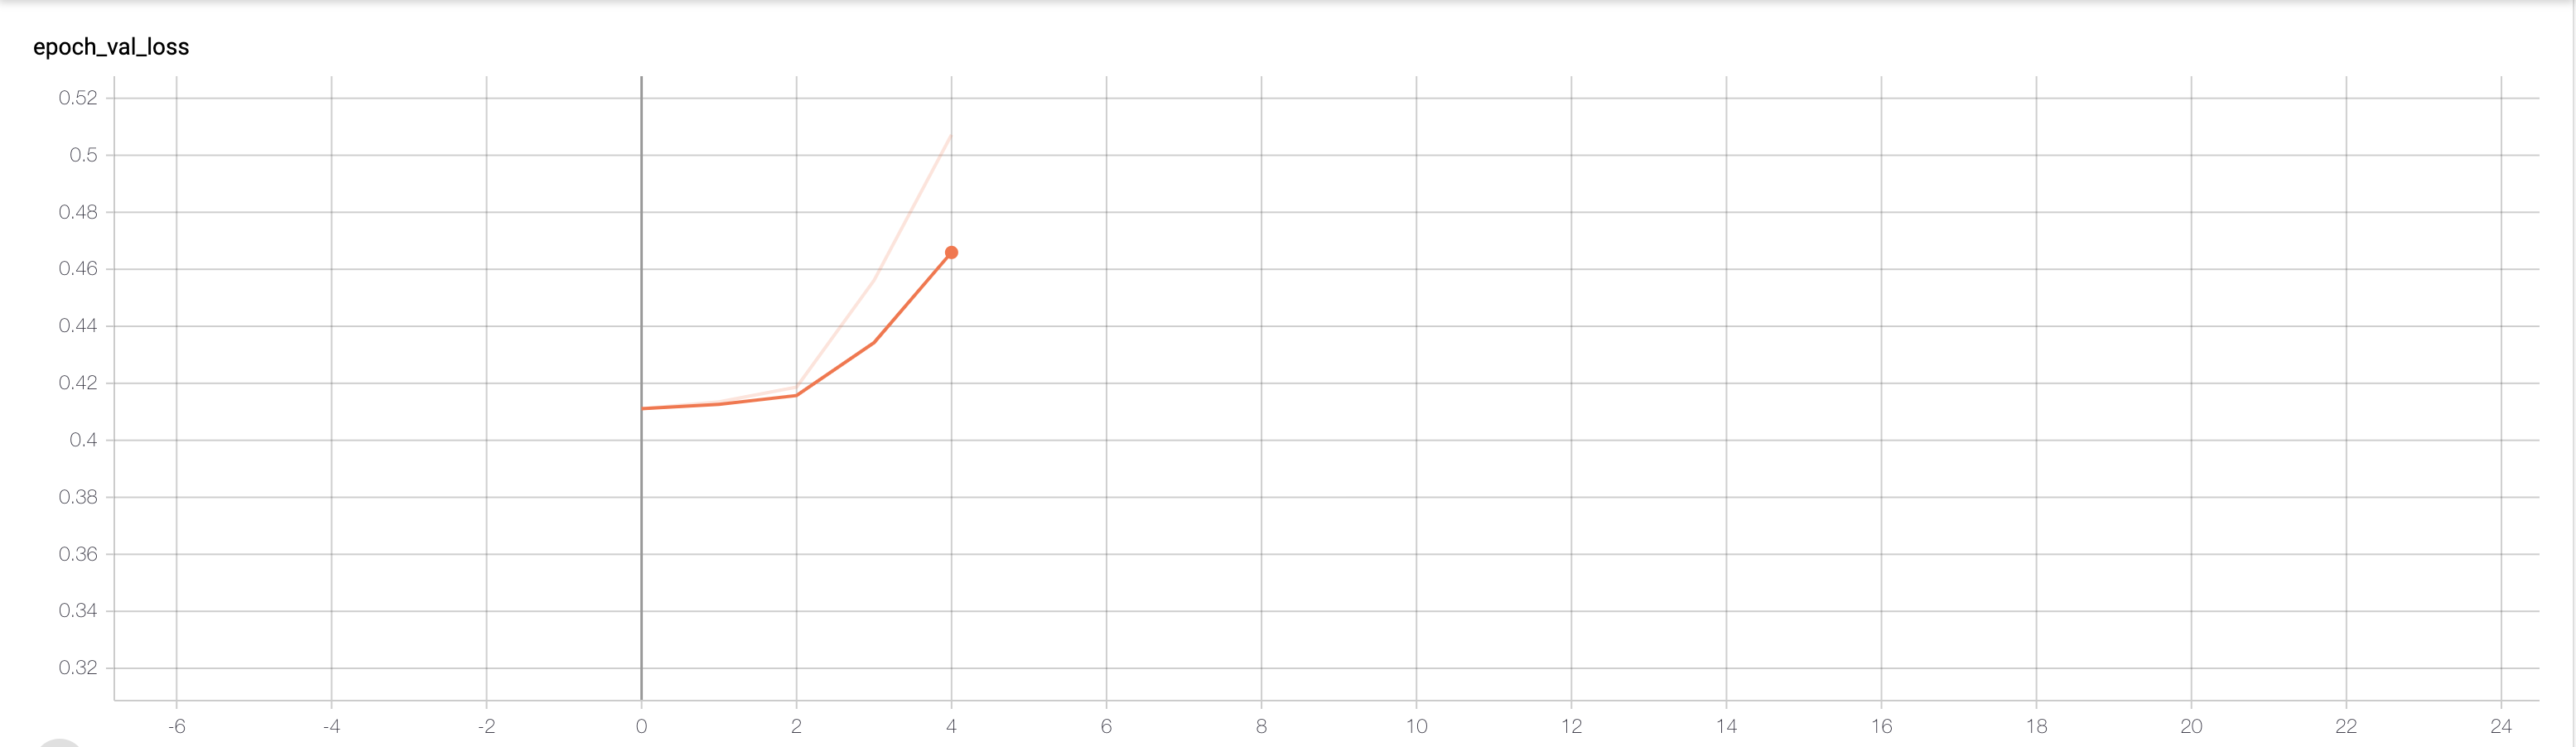

Train Loss


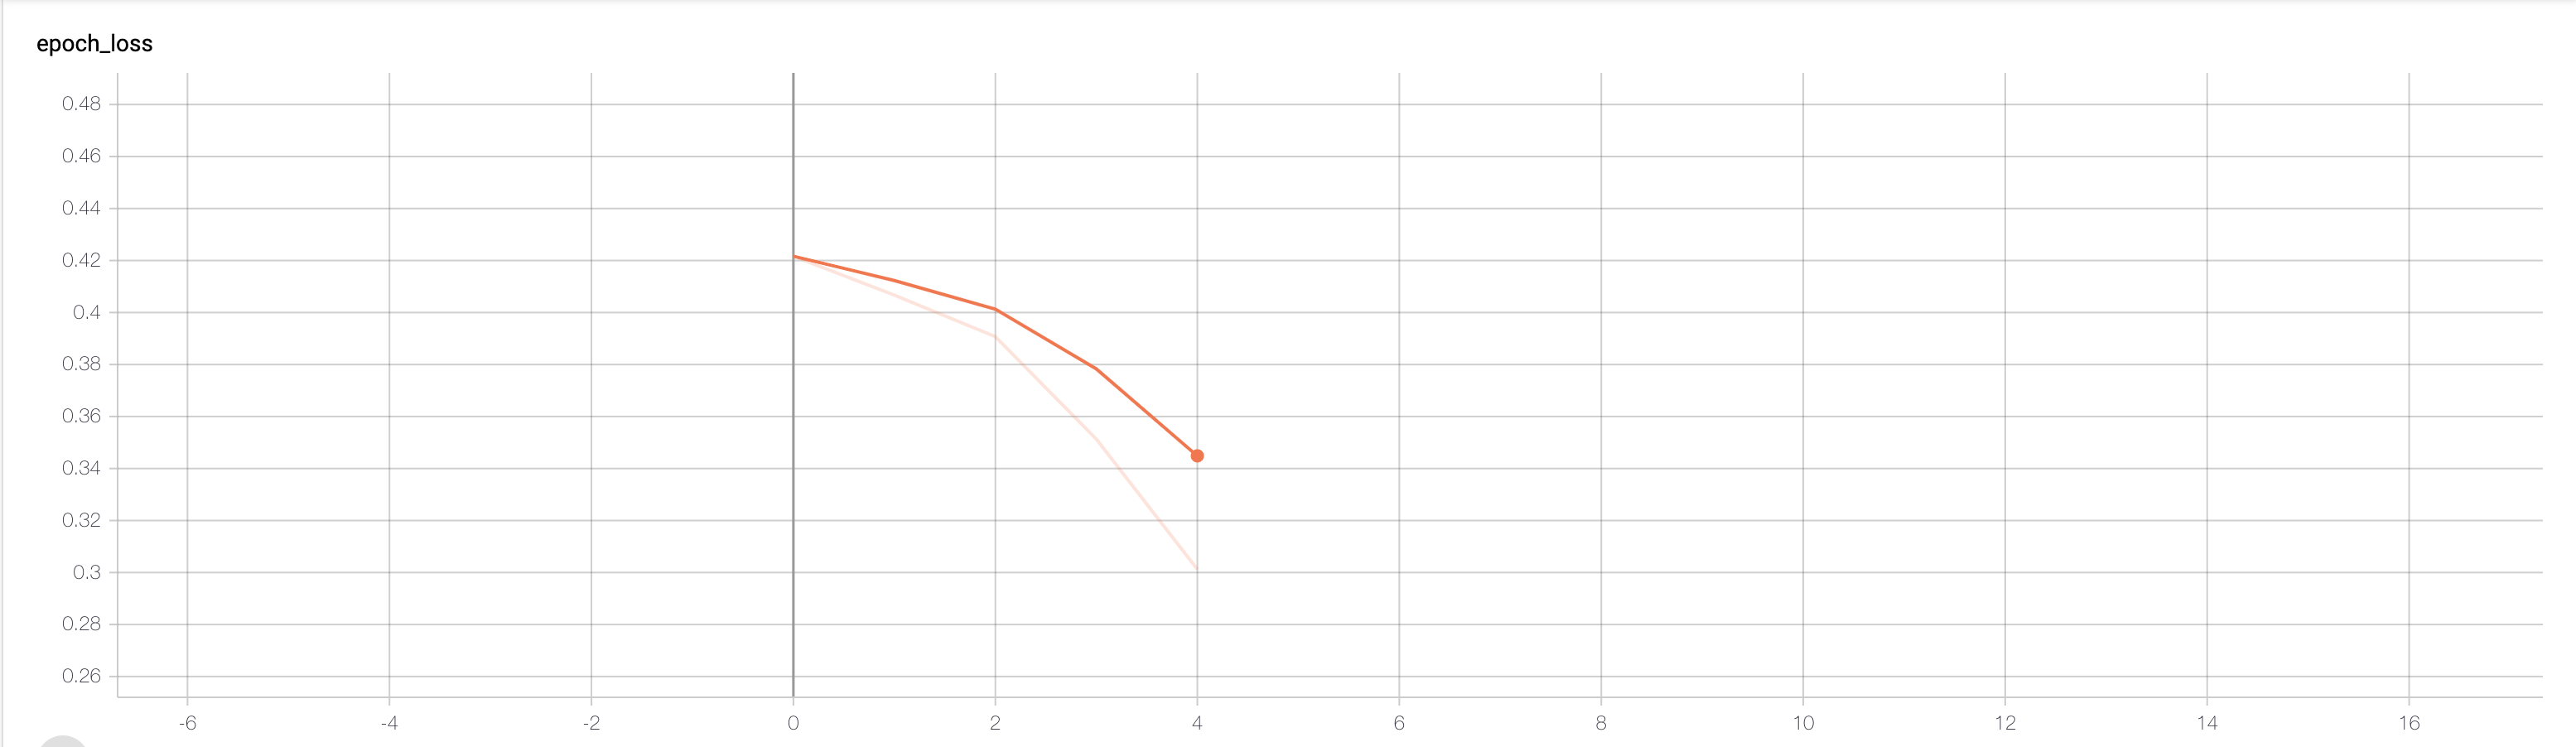

In [118]:
from IPython.display import display, Image
i = Image(filename='./logs2/val_loss.png')
print('Validation Loss')
display(i)
i = Image(filename='./logs2/loss.png')
print('Train Loss')
display(i)

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [120]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(preprocessed_essays_train)

In [121]:
token_train = tokenizer.texts_to_sequences(preprocessed_essays_train)
token_val = tokenizer.texts_to_sequences(preprocessed_essays_val)
token_test = tokenizer.texts_to_sequences(preprocessed_essays_test)

In [122]:
MAX_SEQUENCE_LENGTH = 500
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
final_train = pad_sequences(token_train, maxlen=MAX_SEQUENCE_LENGTH)
final_val = pad_sequences(token_val, maxlen=MAX_SEQUENCE_LENGTH)
final_test = pad_sequences(token_test, maxlen=MAX_SEQUENCE_LENGTH)

Found 49325 unique tokens.


In [123]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [124]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Hstack all other variables

In [125]:
stack_train = np.hstack((keywords_school_state_train, 
                         keywords_grade_train, 
                         keywords_cat_train, 
                         keywords_sub_train,
                         keywords_tech_train,
                         extra_train
                        ))

In [126]:
stack_val = np.hstack((keywords_school_state_val, 
                         keywords_grade_val, 
                         keywords_cat_val, 
                         keywords_sub_val,
                         keywords_tech_val,
                         extra_val
                        ))

In [127]:
stack_test = np.hstack((keywords_school_state_test, 
                         keywords_grade_test, 
                         keywords_cat_test, 
                         keywords_sub_test,
                         keywords_tech_test,
                        extra_test
                       ))

In [128]:
stack_train.shape

(78658, 94)

In [129]:
stack_train = np.expand_dims(stack_train, axis=2)

In [130]:
stack_val = np.expand_dims(stack_val, axis=2)

In [131]:
stack_test = np.expand_dims(stack_test, axis=2)

### Architecture

In [132]:
class Metrics2(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.microauc = None
        self.auc = None

    def on_epoch_end(self, epoch, logs={}):
        score = np.asarray(self.model.predict([self.validation_data[0],self.validation_data[1]]))
        
        targ = self.validation_data[2]
        self.microauc = sklm.roc_auc_score(targ, score,'micro')
        self.auc = sklm.roc_auc_score(targ, score)
        
        print('AUC : {} - roc_auc_micro_avg_score : {}'.format(self.auc,self.microauc))
        return

metrics = Metrics2()

In [133]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32',name='textdata')
embedded_sequences = embedding_layer(sequence_input)
lstm_out = LSTM(500)(embedded_sequences)
lstm_out = Flatten()(embedded_sequences)

In [134]:
input_dim = stack_train.shape[1]

In [135]:
stack_input = Input(shape=(input_dim,1), name='stackdata')
cnn_out = Conv1D(64, kernel_size=(2),activation='relu')(stack_input)
cnn_out = Conv1D(32, kernel_size=(2),activation='relu')(cnn_out)
cnn_out = Flatten()(cnn_out)

In [136]:
model_2 = keras.layers.concatenate([lstm_out, cnn_out])
m2 = Dense(256, activation='relu')(model_2)
m2 = Dropout(0.5)(m2)
m2 = Dense(64, activation='relu')(m2)
m2 = Dropout(0.5)(m2)
m2 = Dense(16, activation='relu')(m2)
m2 = Dense(2, activation='softmax',name='main_output')(m2)

In [137]:
model = Model(inputs=[sequence_input, stack_input], outputs=[m2])

In [138]:
tensorboard = TensorBoard(log_dir='./logs3/{}'.format(time()))

In [139]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[auc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stackdata (InputLayer)          (None, 94, 1)        0                                            
__________________________________________________________________________________________________
textdata (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 93, 64)       192         stackdata[0][0]                  
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 500, 300)     14797800    textdata[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (

In [140]:
model.fit([final_train, stack_train],
          y_train,validation_data=([final_val, stack_val],y_val),
          epochs=5, batch_size=32, callbacks=[tensorboard, metrics])

Train on 78658 samples, validate on 8740 samples
Epoch 1/5
78658/78658 [==============================] - 1389s 18ms/step - loss: 0.4380 - auc: 0.8531 - val_loss: 0.4275 - val_auc: 0.8647
AUC : 0.6037804037048531 - roc_auc_micro_avg_score : 0.8757793215129157
Epoch 2/5
78658/78658 [==============================] - 1386s 18ms/step - loss: 0.4106 - auc: 0.8699 - val_loss: 0.4206 - val_auc: 0.8745
AUC : 0.661720333552916 - roc_auc_micro_avg_score : 0.8906188962606497
Epoch 3/5
78658/78658 [==============================] - 1383s 18ms/step - loss: 0.3959 - auc: 0.8794 - val_loss: 0.4138 - val_auc: 0.8830
AUC : 0.6622168733891654 - roc_auc_micro_avg_score : 0.8907460700427818
Epoch 4/5
78658/78658 [==============================] - 1381s 18ms/step - loss: 0.3807 - auc: 0.8870 - val_loss: 0.4039 - val_auc: 0.8899
AUC : 0.6659116214804938 - roc_auc_micro_avg_score : 0.8916923558273857
Epoch 5/5
78658/78658 [==============================] - 1377s 17ms/step - loss: 0.3676 - auc: 0.8930 - val_

In [141]:
score = model.predict([final_test, stack_test])

In [142]:
Eval(score,np.array(y_test))

AUC : 0.6640916587882109 - roc_auc_micro_avg_score : 0.8904899067387901


In [143]:
scores = model.evaluate([final_test, stack_test],
                        [y_test], verbose=0)

In [144]:
print(scores[0])
print(scores[1])

0.4055707481851294
0.8952713820645138


### Results for Model 3

Validation Loss


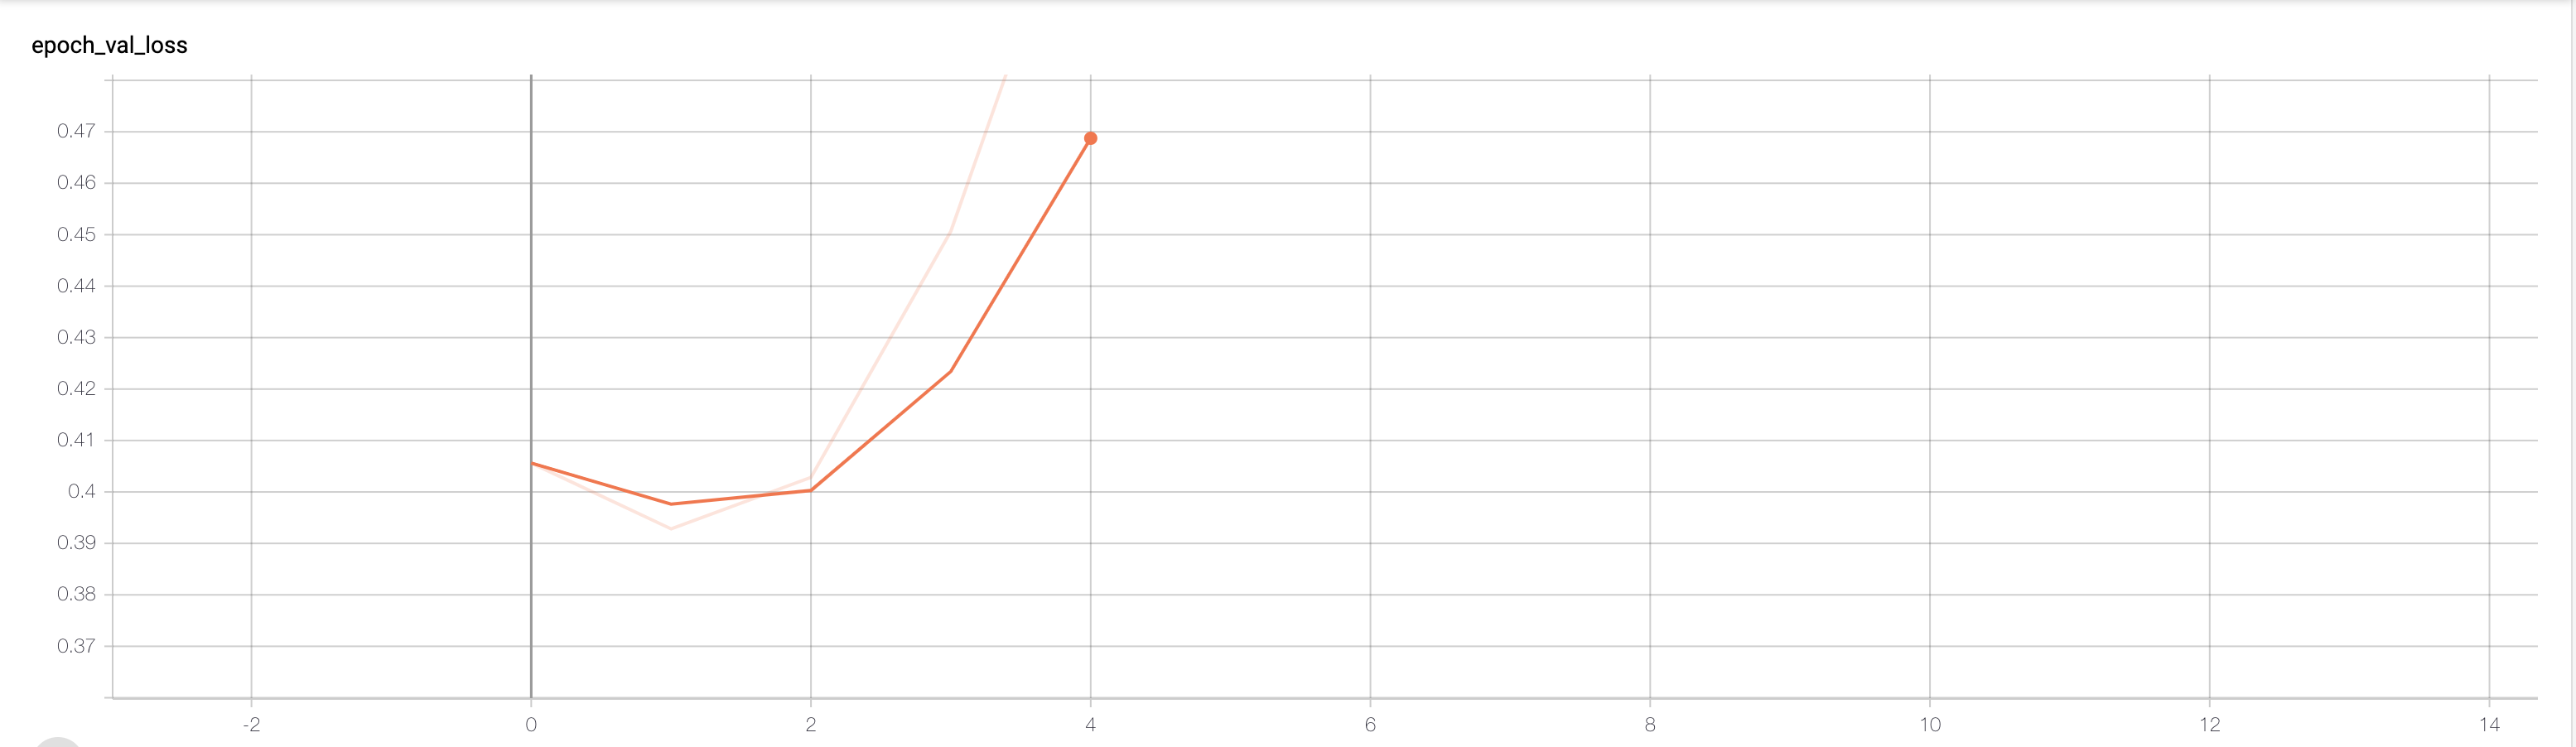

Train Loss


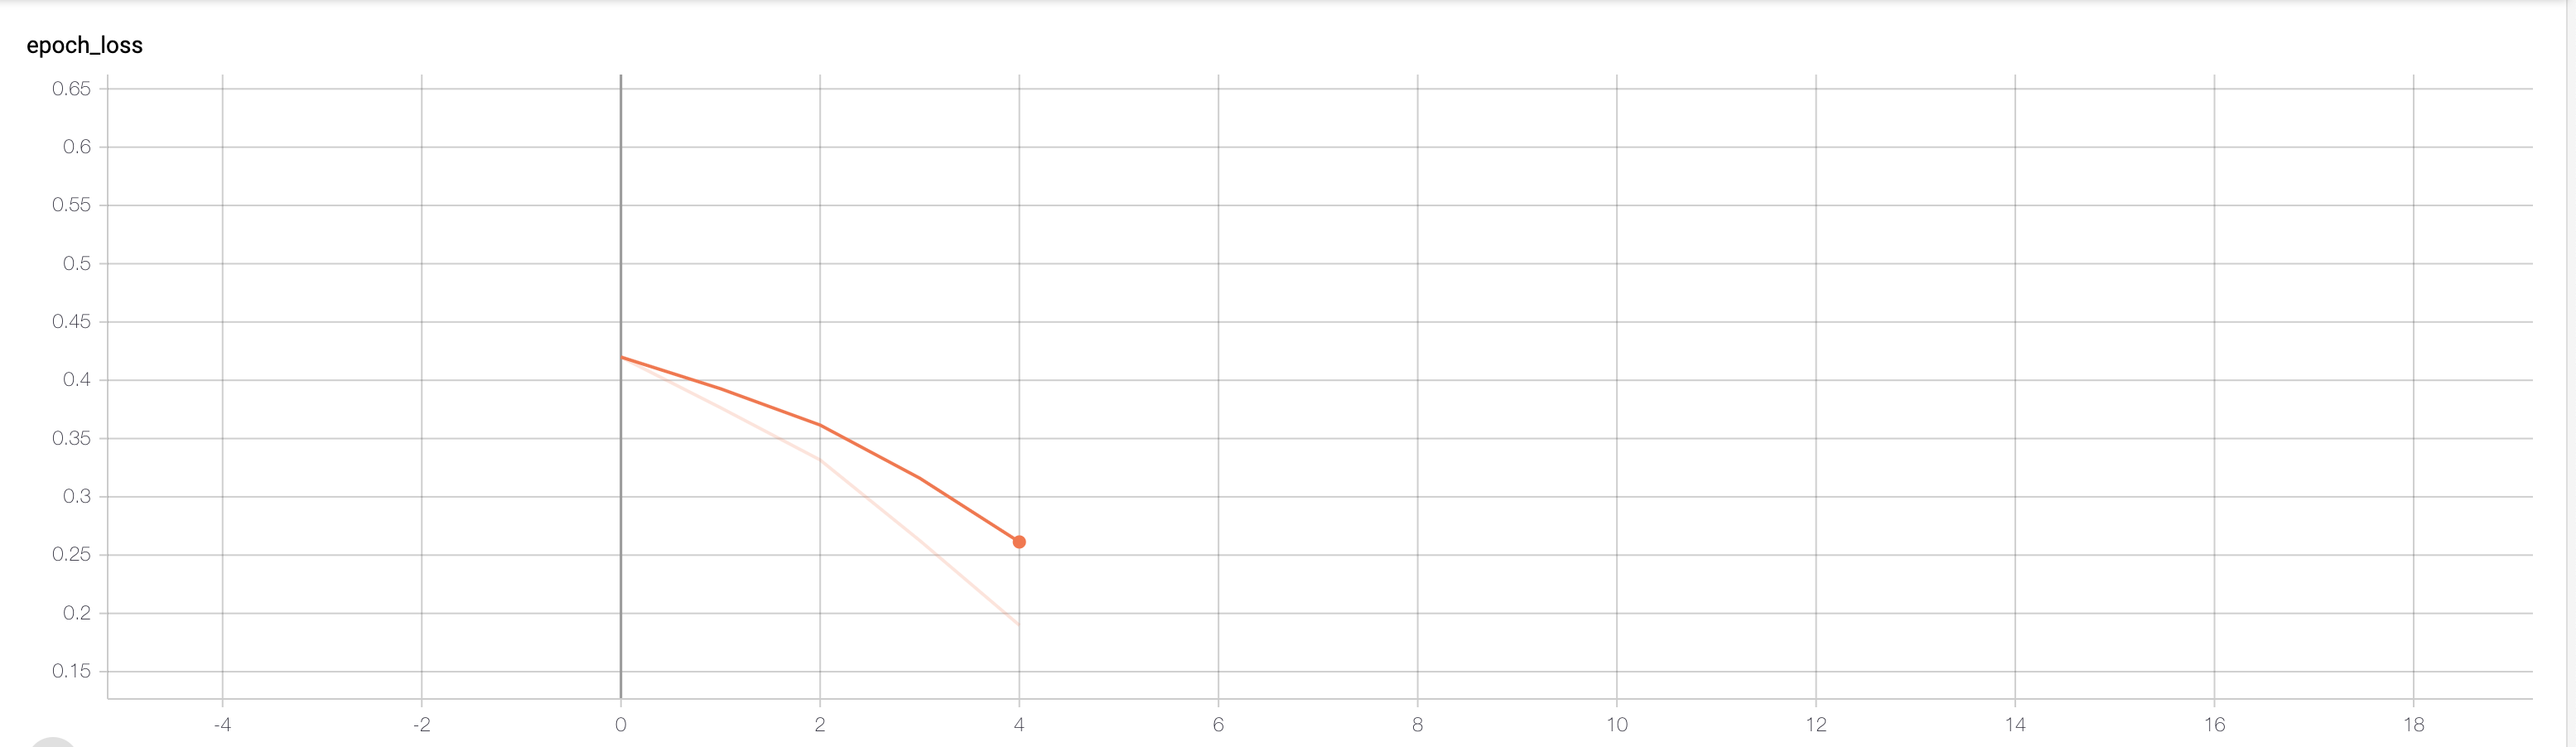

In [145]:
from IPython.display import display, Image
i = Image(filename='./logs3/val_loss.png')
print('Validation Loss')
display(i)
i = Image(filename='./logs3/loss.png')
print('Train Loss')
display(i)

## Conclusion

In [146]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "categorical_crossentropy", "Sklearn AUC", "roc_auc_score with micro avg"
                 ,"Riemann sum AUC"]
x.add_row(["Model 1", 0.8322, 0.6490, 0.8717, 0.9532])
x.add_row(["Model 2", 0.4696, 0.6457, 0.8840, 0.9063])
x.add_row(["Model 3", 0.4055, 0.6641 ,0.8904, 0.8952])
print(x)

+---------+--------------------------+-------------+------------------------------+-----------------+
|  Model  | categorical_crossentropy | Sklearn AUC | roc_auc_score with micro avg | Riemann sum AUC |
+---------+--------------------------+-------------+------------------------------+-----------------+
| Model 1 |          0.8322          |    0.649    |            0.8717            |      0.9532     |
| Model 2 |          0.4696          |    0.6457   |            0.884             |      0.9063     |
| Model 3 |          0.4055          |    0.6641   |            0.8904            |      0.8952     |
+---------+--------------------------+-------------+------------------------------+-----------------+
